## Creating partition tree ##
The notebook creates the partition from the counts of measurements collected for each station. This part is small enough to fit in memory, so hadoop is not used.

In [1]:
!s3cmd get s3://Weather.GHNC/compiled_statistics.pkl.gz compiled_statistics.pkl.gz

/bin/sh: s3cmd: command not found


In [ ]:
!rm compiled_statistics.pkl
!gunzip compiled_statistics.pkl.gz

In [1]:
!ls -l *.pkl*

-rw-r--r--  1 yoavfreund  staff     5672567 May 20 10:42 Partition_Tree.pkl
-rw-r--r--  1 yoavfreund  staff       11371 May 17 21:05 StationStatistics.pkl
-rw-r--r--  1 yoavfreund  staff   107043420 May 17 21:32 Statistics.pkl
-rw-r--r--  1 yoavfreund  staff    81159389 May 17 11:24 Statistics.pkl.gz
-rw-r--r--  1 yoavfreund  staff  1080101924 May 18 01:41 compiled_statistics.pkl
-rw-r--r--  1 yoavfreund  staff     8051413 May 11 21:59 stations.pkl


In [2]:
import pickle
Data=pickle.load(open('compiled_statistics.pkl','rb'))
type(Data)

dict

In [3]:
Data.keys()

['counts_by_type', 'All_Counts']

In [4]:
All_Counts=Data['All_Counts']
import pandas as pd
type(All_Counts),shape(All_Counts)

(pandas.core.frame.DataFrame, (9357954, 4))

In [5]:
All_Counts.head()

count      station  type  year
0    365  AJ000037899  PRCP  1984
1     48  AJ000037899  TMAX  1989
2      9  AJ000037899  TMIN  1989
3    335  AJ000037899  PRCP  1978
4    355  AJ000037899  PRCP  1936

[5 rows x 4 columns]

Use only TMIN/TMAX/PRCP measurements for which you have more than 300 days measured (out of 365)

In [6]:
selector=((All_Counts['type'] == 'TMIN') |\
          (All_Counts['type'] == 'TMAX') |\
          (All_Counts['type'] == 'PRCP'))&\
        (All_Counts['count']>300)

In [7]:
#print how many entries there are to select from and how many of these were selected
print 'From',shape(selector)[0],' entries, selected',sum(selector)

From 9357954  entries, selected 3752489


In [8]:
#Tmps holds the selected rows.
Tmps=All_Counts.loc[selector]
shape(Tmps)

(3752489, 4)

In [9]:
# Sum the counts for each station.
Stat_W=Tmps.groupby('station')['count'].sum()
print 'total selected stations=',len(Stat_W)
print Stat_W.head()

total selected stations= 72701
station
ACW00011647     3169
AE000041196    12219
AG000060390    68009
AG000060590    72854
AG000060611    50449
Name: count, dtype: int64


In [10]:
# sort the stations by weight and show a few of the lightest and haviest ones
Stat_W.sort()
print 'lightest\n',Stat_W.head()
print 'heaviest\n',Stat_W.tail()
Total_Weight=sum(Stat_W)
print 'total Weight=',Total_Weight,'The heaviest station fraction of total weight',float(Stat_W[-1])/Total_Weight

lightest
station
US1COWE0177    301
US1MEHN0028    301
US1ORJC0005    301
USC00418763    301
USC00354129    301
Name: count, dtype: int64
heaviest
station
CA006158350    175732
GM000004204    198379
ITE00100550    209868
ITE00100554    234448
EZE00100082    240808
Name: count, dtype: int64
total Weight= 1347043822 The heaviest station fraction of total weight 0.00017876775504


In [11]:
!ls *pkl*

Partition_Tree.pkl      StationStatistics.pkl   Statistics.pkl          Statistics.pkl.gz       compiled_statistics.pkl stations.pkl


In [12]:
Stations=pickle.load(open('stations.pkl','rb'))

In [13]:
Stations.head()

latitude  longitude  elevation state                   name  \
ACW00011604   17.1167   -61.7833       10.1   NaN  ST JOHNS COOLIDGE FLD   
ACW00011647   17.1333   -61.7833       19.2   NaN               ST JOHNS   
AE000041196   25.3330    55.5170       34.0   NaN    SHARJAH INTER. AIRP   
AF000040930   35.3170    69.0170     3366.0   NaN           NORTH-SALANG   
AG000060390   36.7167     3.2500       24.0   NaN     ALGER-DAR EL BEIDA   

            GSNFLAG HCNFLAG  WMOID  
ACW00011604     NaN     NaN    NaN  
ACW00011647     NaN     NaN    NaN  
AE000041196     GSN     NaN  41196  
AF000040930     GSN     NaN  40930  
AG000060390     GSN     NaN  60390  

[5 rows x 8 columns]

In [14]:
#Add column called "weight" to the stations
Stations['weight']=Stat_W
Stations.head()

latitude  longitude  elevation state                   name  \
ACW00011604   17.1167   -61.7833       10.1   NaN  ST JOHNS COOLIDGE FLD   
ACW00011647   17.1333   -61.7833       19.2   NaN               ST JOHNS   
AE000041196   25.3330    55.5170       34.0   NaN    SHARJAH INTER. AIRP   
AF000040930   35.3170    69.0170     3366.0   NaN           NORTH-SALANG   
AG000060390   36.7167     3.2500       24.0   NaN     ALGER-DAR EL BEIDA   

            GSNFLAG HCNFLAG  WMOID  weight  
ACW00011604     NaN     NaN    NaN     NaN  
ACW00011647     NaN     NaN    NaN    3169  
AE000041196     GSN     NaN  41196   12219  
AF000040930     GSN     NaN  40930     NaN  
AG000060390     GSN     NaN  60390   68009  

[5 rows x 9 columns]

In [15]:
Stat_W[Stat_W<0]  #Sanity Check - should be empty

Series([], name: count, dtype: int64)

In [16]:
ALL_Stations=Stations.dropna(subset=['weight'])
shape(ALL_Stations), shape(Stations)

((72701, 9), (85284, 9))

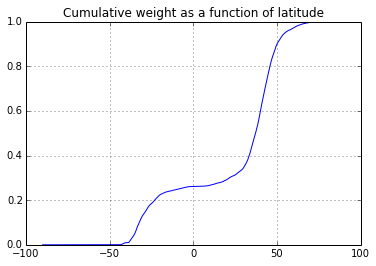

In [17]:
coord='latitude' # Try also longitude
ALL_Stations=ALL_Stations.sort(columns=[coord])
S=cumsum(ALL_Stations['weight'])
S=S/S[-1]
plot(ALL_Stations[coord],S);
grid();
title('Cumulative weight as a function of '+coord);

In [18]:
# A utility function for finding a given percentile p in a cumulative sum list: S
def find_p(p,S):
    """ Binary search in a sorted list """
    n=len(S)/2
    if n<3:
        return -1
    step=n/2
    dir=1
    #print len(S)
    while True:
        if n<0: n=0
        if n>len(S)-1: n=len(S)-1
        #print n,S[n]
        if (S[n]-p)*dir>0:
            step=-step/2
            dir=-dir
        if step==0:
            break
        n+=step
    return n

## The station grouping code

In [19]:
## Setup
level=0
coords=['latitude','longitude']
coord_i=0
coord=''
global Node_counter
Node_counter=0 # a counter of the order in which elements are added to Thresholds
current_node=()
# The main two data structures are:
# ALL_Stations which is a pandas dataframe and holds, 
# in the column 'Node' the ID of the node to which the station belongs.
# Thresholds: Holds the partition tree and the parameters corresponding to each split 
# (the threhold) and each node (lat_min,lat_max,long_min,long_max,neighbors)
ALL_Stations['Node']=[tuple() for i in range(len(ALL_Stations))]
ALL_Stations['block']=[tuple() for i in range(len(ALL_Stations))]
Thresholds={}

### Function for splitting into fixed size cubes

In [20]:
def rough_split(Stations,n_lat=10,n_long=20):
    """ Partition stations into n_lat X n_long rectangles of equal size """
    long_step=360/n_long
    lat_step=180/n_lat
    count=0
    block=[[]]*len(Stations)
    for all_row in ALL_Stations.iterrows():
        row=all_row[1]
        q_long=int(float(row['longitude'])/long_step)*long_step
        q_lat=int(float(row['latitude'])/lat_step)*lat_step
        block[count]=(q_lat,q_long)
        #print row.loc['longitude'],q_long
        #print row.loc['latitude'],q_lat
        count+=1
    return block
#block=rough_split(ALL_Stations) 
#shape(block),shape(ALL_Stations)
#ALL_Stations['block']=block

In [21]:
ALL_Stations.head()

latitude  longitude  elevation state               name GSNFLAG  \
AYW00090001  -90.0000     0.0000     -999.9   NaN     AMUNDSEN-SCOTT     GSN   
AYW00068201  -80.0167  -119.5333     1543.2   NaN           BYRD STN     NaN   
AYW00077401  -79.4667    40.5833     3505.2   NaN        PLATEAU STN     NaN   
AYW00067601  -78.2000  -162.2500       32.0   NaN     LITTLE AMERICA     NaN   
AY000896640  -77.8833   166.7333       24.1   NaN  MCMURDO SOUND NAF     NaN   

            HCNFLAG  WMOID  weight Node block  
AYW00090001     NaN  89009   40392   ()    ()  
AYW00068201     NaN  89125   14117   ()    ()  
AYW00077401     NaN    NaN    3235   ()    ()  
AYW00067601     NaN    NaN    3148   ()    ()  
AY000896640     NaN  89674   38102   ()    ()  

[5 rows x 11 columns]

Splitting a node according the median in one of two coordinates: Longitude or Latitude.

In [22]:
def splitter(Stations):
    global Node_counter

    #print '>>>>>>>>>>>'
    #print 'entered splitter','level=',level,'coord=',coord,'shape=',shape(Stations)
    This_Key = Stations['Node'].unique()
    This_Block=Stations['block'].unique()
    assert len(This_Key)==1 & len(This_Block)==1
    This_Key=This_Key[0]; This_Block=This_Block[0]
    #print 'Incoming Key=',This_Block,This_Key,shape(Stations)
    # If there are too few stations in the node or if the heviest station is more than
    # half the total weight, then don't split the node
    if shape(Stations)[0]<10:
        return Stations
    Largest=Stations['weight'].max()
    if Largest/Stations['weight'].sum() > 0.5:
        return Stations
    
    # find weighted median split point
    Stations_sorted=Stations.sort(columns=[coord])
    S=cumsum(Stations_sorted['weight'])
    #print 'Total Weight=',S[-1]
    S=S/S[-1]
    index=find_p(0.5,S)
    if index>-1:  # if returned value is -1 then we don't split
        #print 'index=',index,
        threshold=Stations_sorted.ix[index,coord]
        #print ' threshold=',threshold
        Thresholds[(This_Block,This_Key)]={'coord':coord,'threshold':threshold,'counter':Node_counter}
        Node_counter+=1

        # Split according to split point
        split=Stations[coord]>threshold
        Stations['Node']=[(Stations.ix[i,'Node']+(split[i],)) for i in range(len(split))]
        #print shape(Stations)
        #print 'Outgoing Keys=',Stations['Node'].unique()
        #print '<<<<<<<<<<<'
    return Stations

In [23]:
for level in range(8):
    coord_i=(coord_i+1) % 2
    coord=coords[coord_i]
    print '------------------------------- level=',level,'coord=',coord
    print (ALL_Stations.groupby(['block','Node']))['weight'].sum()
    if level==0:
        block=rough_split(ALL_Stations)
        ALL_Stations['block']=block
    else:
        G=ALL_Stations.groupby(['block','Node'])
        # print 'Split into groups=',G.groups.keys()
        ALL_Stations=G.apply(splitter)

------------------------------- level= 0 coord= longitude
block  Node
()     ()      1347043822
Name: weight, dtype: float64
------------------------------- level= 1 coord= latitude
block        Node
(-90, 0)     ()      40392
(-72, -162)  ()       3148
(-72, -108)  ()      14117
(-72, -72)   ()       6271
(-72, -36)   ()       3012
(-72, 36)    ()       3235
(-72, 162)   ()      45668
(-54, -54)   ()      49352
(-54, -36)   ()      33090
(-54, 0)     ()       9414
(-54, 54)    ()      37595
(-54, 72)    ()      31579
(-54, 108)   ()      33193
(-36, -162)  ()      34212
(-36, -72)   ()      21534
...
(54, 162)   ()      1171357
(72, -108)  ()        76413
(72, -90)   ()       122289
(72, -72)   ()       203141
(72, -54)   ()       110550
(72, -18)   ()        14093
(72, 0)     ()       216363
(72, 18)    ()       160105
(72, 36)    ()        72233
(72, 54)    ()       141915
(72, 72)    ()       200010
(72, 90)    ()       219062
(72, 108)   ()        45106
(72, 126)   ()       158457

In [24]:
ALL_Stations

latitude  longitude  elevation state  \
AYW00090001  -90.0000     0.0000     -999.9   NaN   
AYW00068201  -80.0167  -119.5333     1543.2   NaN   
AYW00077401  -79.4667    40.5833     3505.2   NaN   
AYW00067601  -78.2000  -162.2500       32.0   NaN   
AY000896640  -77.8833   166.7333       24.1   NaN   
AYW00057401  -77.7333   -41.1167       43.3   NaN   
AYW00057801  -75.9167   -83.9167       54.3   NaN   
AYW00057701  -75.2333   -77.1667      421.2   NaN   
AYW00087701  -72.3000   170.2167        5.2   NaN   
AY000890020  -70.6670    -8.2500       50.0   NaN   
AY000089571  -68.5830    77.9500       13.0   NaN   
AY000089564  -67.6000    62.8670       16.0   NaN   
AY000089611  -66.2830   110.5170       41.0   NaN   
AYW00086101  -66.2667   110.5667       12.2   NaN   
AY000890550  -64.2330   -56.7170      198.0   NaN   
AY000889630  -63.4000   -56.9830       24.0   NaN   
AY000889680  -60.7330   -44.7330        8.0   NaN   
CI000085934  -53.0000   -70.9670       37.0   NaN   
NZ000939450  -52.5500   169.1670       19.0   NaN   
AR000087925  -51.6170   -69.2830       19.0   NaN   
SF000068994  -46.8830    37.8670       21.0   NaN   
NZ000093844  -46.4170   168.3330        2.0   NaN   
CI000085874  -45.9170   -71.7000      525.0   NaN   
AR000087860  -45.7830   -67.5000       58.0   NaN   
NZ000937470  -44.5170   169.9000      488.0   NaN   
NZ000939870  -43.9500  -176.5670       49.0   NaN   
ASN00094041  -43.6578   146.2711      146.5   NaN   
ASN00094013  -43.6000   146.9000     -999.9   NaN   
ASN00094010  -43.4892   147.1453       55.0   NaN   
ASN00094198  -43.4886   147.1444       59.7   NaN   
ASN00097007  -43.4297   146.1597        6.0   NaN   
ASN00094032  -43.4225   146.9725       20.0   NaN   
ASN00094027  -43.4144   146.8731       35.0   NaN   
ASN00094192  -43.4086   146.9567      120.0   NaN   
ASN00094000  -43.4000   147.3500       12.2   NaN   
ASN00094236  -43.3692   147.3442        3.0   NaN   
ASN00094131  -43.3667   147.3333        2.0   NaN   
ASN00094039  -43.3583   147.2342       22.0   NaN   
ASN00094159  -43.3531   147.3147       81.0   NaN   
ASN00094217  -43.3292   147.3208       40.0   NaN   
ASN00094070  -43.3181   147.2467        6.0   NaN   
ASN00094020  -43.3167   147.0075       17.0   NaN   
ASN00094075  -43.2500   148.0000      239.9   NaN   
ASN00097029  -43.2500   145.9000     -999.9   NaN   
ASN00094155  -43.2397   148.0025      240.0   NaN   
ASN00094043  -43.2319   147.2547       25.0   NaN   
ASN00094057  -43.2167   147.3833       16.8   NaN   
ASN00094167  -43.2147   147.3783       30.0   NaN   
ASN00094191  -43.2006   146.7683      831.0   NaN   
AR000087828  -43.2000   -65.2660       43.0   NaN   
ASN00094073  -43.2000   147.0667     -999.9   NaN   
ASN00094080  -43.2000   147.1000     -999.9   NaN   
ASN00094050  -43.2000   147.0000       27.4   NaN   
ASN00094028  -43.2000   147.7500     -999.9   NaN   
ASN00094040  -43.1983   147.0658       26.0   NaN   
ASN00094225  -43.1833   146.9869       27.0   NaN   
ASN00094206  -43.1753   147.1539      110.0   NaN   
ASN00094150  -43.1667   146.9500     -999.9   NaN   
ASN00094133  -43.1667   147.2333      130.0   NaN   
ASN00094024  -43.1667   146.9333       18.3   NaN   
                  ...        ...        ...   ...   

                                       name GSNFLAG HCNFLAG  WMOID  weight  \
AYW00090001                  AMUNDSEN-SCOTT     GSN     NaN  89009   40392   
AYW00068201                        BYRD STN     NaN     NaN  89125   14117   
AYW00077401                     PLATEAU STN     NaN     NaN    NaN    3235   
AYW00067601                  LITTLE AMERICA     NaN     NaN    NaN    3148   
AY000896640               MCMURDO SOUND NAF     NaN     NaN  89674   38102   
AYW00057401                   ELLSWORTH IGY     NaN     NaN    NaN    3012   
AYW00057801                       SIPLE STN     NaN     NaN  89083    3277   
AYW00057701                          EIGHTS     NaN     NaN    NaN    2994   
AYW00087701             

In [25]:
def logical201(key):
    out=''
    for i in range(len(key)):
        if key[i]:
            out += '1'
        else:
            out += '0'
    return out
logical201((False, False, False, False, False, False, False, False, True))

'000000001'

In [30]:
keys=Thresholds.keys()
print '\n'.join(['%15s\t%s:\t%s\t%6.3f'%(str(key[0]),logical201(key[1]),Thresholds[key]['coord'],Thresholds[key]['threshold']) for key in keys])

       (36, 18)	00:	latitude	44.517
        (0, 72)	001110:	latitude	12.420
     (18, -144)	11111:	longitude	-157.783
     (-18, -36)	101001:	latitude	-20.920
      (-18, 18)	011100:	latitude	-31.070
       (0, 126)	00111:	longitude	132.155
       (18, 90)	1:	longitude	97.167
      (36, -72)	011011:	latitude	40.500
       (36, 36)	0010:	latitude	43.683
        (0, 72)	111010:	latitude	17.400
      (36, -72)	00001:	longitude	-87.785
       (0, -54)	001000:	latitude	-4.670
     (-18, 108)	100:	longitude	116.007
      (36, -90)	111010:	latitude	49.330
     (18, -144)	11:	latitude	21.300
      (36, -54)	01101:	longitude	-68.167
       (36, 36)	000001:	latitude	41.600
      (36, -54)	1000:	latitude	46.430
     (-36, 126)	0000:	latitude	-38.057
       (18, 72)	1111:	latitude	26.720
      (36, -54)	000:	longitude	-71.283
     (-36, 144)	010000:	latitude	-43.167
       (0, -54)	11000:	longitude	-64.490
      (36, -72)	011:	longitude	-76.717
     (-36, 144)	0011:	latitude	-38.200
     (18, -108

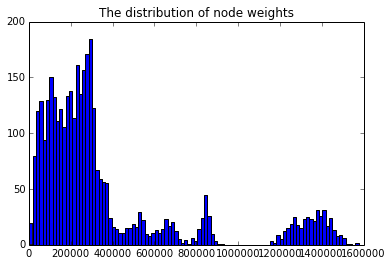

In [37]:
Weights=(ALL_Stations.groupby(['block','Node']))['weight'].sum()
hist(Weights.values,bins=100);
title('The distribution of node weights')

In [44]:
# Storing the partition tree as a dataframe
keys=Thresholds.keys()
coords=[]
counters=[]
thresholds=[]
b_keys=[]
blocks=[]
for key in keys:
    blocks.append(key[0])
    b_keys.append(logical201(key[1]))
    item=Thresholds[key]
    coords.append(item['coord'])
    counters.append(item['counter'])
    thresholds.append(item['threshold'])
Partition_Tree=pd.DataFrame(data={'block':blocks,'key':b_keys,'coord':coords,'threshold':thresholds,'counter':counters})

In [46]:
Partition_Tree.head()

block      coord  counter     key  threshold
0    (36, 18)   latitude      357      00    44.5167
1     (0, 72)   latitude     2792  001110    12.4200
2  (18, -144)  longitude     1798   11111  -157.7833
3  (-18, -36)   latitude     2416  101001   -20.9200
4   (-18, 18)   latitude     2467  011100   -31.0700

[5 rows x 5 columns]

In [47]:
Partition_Tree['level']=(Partition_Tree['key']).apply(len)
Partition_Tree.sort(columns=['counter']).head()

block     coord  counter key  threshold  level
869   (-36, -54)  latitude        0       -43.2000      0
2021  (-36, 126)  latitude        1       -37.2472      0
3141  (-36, 144)  latitude        2       -37.9000      0
2840  (-18, -54)  latitude        3       -30.2670      0
2550  (-18, -36)  latitude        4       -22.2700      0

[5 rows x 6 columns]

In [51]:
ALL_Stations

latitude  longitude  elevation state  \
AYW00090001  -90.0000     0.0000     -999.9   NaN   
AYW00068201  -80.0167  -119.5333     1543.2   NaN   
AYW00077401  -79.4667    40.5833     3505.2   NaN   
AYW00067601  -78.2000  -162.2500       32.0   NaN   
AY000896640  -77.8833   166.7333       24.1   NaN   
AYW00057401  -77.7333   -41.1167       43.3   NaN   
AYW00057801  -75.9167   -83.9167       54.3   NaN   
AYW00057701  -75.2333   -77.1667      421.2   NaN   
AYW00087701  -72.3000   170.2167        5.2   NaN   
AY000890020  -70.6670    -8.2500       50.0   NaN   
AY000089571  -68.5830    77.9500       13.0   NaN   
AY000089564  -67.6000    62.8670       16.0   NaN   
AY000089611  -66.2830   110.5170       41.0   NaN   
AYW00086101  -66.2667   110.5667       12.2   NaN   
AY000890550  -64.2330   -56.7170      198.0   NaN   
AY000889630  -63.4000   -56.9830       24.0   NaN   
AY000889680  -60.7330   -44.7330        8.0   NaN   
CI000085934  -53.0000   -70.9670       37.0   NaN   
NZ000939450  -52.5500   169.1670       19.0   NaN   
AR000087925  -51.6170   -69.2830       19.0   NaN   
SF000068994  -46.8830    37.8670       21.0   NaN   
NZ000093844  -46.4170   168.3330        2.0   NaN   
CI000085874  -45.9170   -71.7000      525.0   NaN   
AR000087860  -45.7830   -67.5000       58.0   NaN   
NZ000937470  -44.5170   169.9000      488.0   NaN   
NZ000939870  -43.9500  -176.5670       49.0   NaN   
ASN00094041  -43.6578   146.2711      146.5   NaN   
ASN00094013  -43.6000   146.9000     -999.9   NaN   
ASN00094010  -43.4892   147.1453       55.0   NaN   
ASN00094198  -43.4886   147.1444       59.7   NaN   
ASN00097007  -43.4297   146.1597        6.0   NaN   
ASN00094032  -43.4225   146.9725       20.0   NaN   
ASN00094027  -43.4144   146.8731       35.0   NaN   
ASN00094192  -43.4086   146.9567      120.0   NaN   
ASN00094000  -43.4000   147.3500       12.2   NaN   
ASN00094236  -43.3692   147.3442        3.0   NaN   
ASN00094131  -43.3667   147.3333        2.0   NaN   
ASN00094039  -43.3583   147.2342       22.0   NaN   
ASN00094159  -43.3531   147.3147       81.0   NaN   
ASN00094217  -43.3292   147.3208       40.0   NaN   
ASN00094070  -43.3181   147.2467        6.0   NaN   
ASN00094020  -43.3167   147.0075       17.0   NaN   
ASN00094075  -43.2500   148.0000      239.9   NaN   
ASN00097029  -43.2500   145.9000     -999.9   NaN   
ASN00094155  -43.2397   148.0025      240.0   NaN   
ASN00094043  -43.2319   147.2547       25.0   NaN   
ASN00094057  -43.2167   147.3833       16.8   NaN   
ASN00094167  -43.2147   147.3783       30.0   NaN   
ASN00094191  -43.2006   146.7683      831.0   NaN   
AR000087828  -43.2000   -65.2660       43.0   NaN   
ASN00094073  -43.2000   147.0667     -999.9   NaN   
ASN00094080  -43.2000   147.1000     -999.9   NaN   
ASN00094050  -43.2000   147.0000       27.4   NaN   
ASN00094028  -43.2000   147.7500     -999.9   NaN   
ASN00094040  -43.1983   147.0658       26.0   NaN   
ASN00094225  -43.1833   146.9869       27.0   NaN   
ASN00094206  -43.1753   147.1539      110.0   NaN   
ASN00094150  -43.1667   146.9500     -999.9   NaN   
ASN00094133  -43.1667   147.2333      130.0   NaN   
ASN00094024  -43.1667   146.9333       18.3   NaN   
                  ...        ...        ...   ...   

                                       name GSNFLAG HCNFLAG  WMOID  weight  \
AYW00090001                  AMUNDSEN-SCOTT     GSN     NaN  89009   40392   
AYW00068201                        BYRD STN     NaN     NaN  89125   14117   
AYW00077401                     PLATEAU STN     NaN     NaN    NaN    3235   
AYW00067601                  LITTLE AMERICA     NaN     NaN    NaN    3148   
AY000896640               MCMURDO SOUND NAF     NaN     NaN  89674   38102   
AYW00057401                   ELLSWORTH IGY     NaN     NaN    NaN    3012   
AYW00057801                       SIPLE STN     NaN     NaN  89083    3277   
AYW00057701                          EIGHTS     NaN     NaN    NaN    2994   
AYW00087701             

In [49]:
ALL_Stations['Node']=ALL_Stations['Node'].apply(logical201)
ALL_Stations.Node.values

array(['', '', '', ..., '', '', ''], dtype=object)

In [52]:
pickle.dump({'Partition_Tree':Partition_Tree,\
             'Partitioned_Stations':ALL_Stations},\
            open('Partition_Tree.pkl','wb'))

In [53]:
ALL_Stations=ALL_Stations.sort('Node')
ALL_Stations.iloc[1000:1020,:]

latitude  longitude  elevation state                 name  \
CA004064149   55.1500  -105.2700      379.0   NaN         LA RONGE RCS   
RSM00030437   55.1500   107.6170      497.0   NaN                KARAM   
CA004064150   55.1500  -105.2670      379.0     K     LA RONGE AIRPORT   
RSM00030439   55.1170   109.7500      465.0   NaN                TOMPA   
RSM00030469   55.1170   116.7670      613.0   NaN              KALAKAN   
CA004064130   55.1000  -105.3000      372.0   NaN     LA RONGE AIRPORT   
ET000063474    7.1330    40.0000     2480.0   NaN            ROBE/BALE   
LYW00033123   32.9000    13.2833       13.1   NaN              WHEELUS   
CH000052866   36.6170   101.7670     2296.0   NaN               XINING   
WA007841360  -22.2700    17.0800     1660.0   NaN              GUSINDE   
IN005051200   22.1700    71.6700      120.0   NaN                BOTAD   
RSM00030682   53.8670   120.8670      472.0   NaN               AMAZAR   
JA000047945   25.9330   131.3170       24.0   NaN            KITADAITO   
TZ000063962  -10.6670    35.5830     1036.0   NaN               SONGEA   
BR038484280   -7.2170   -35.8830      502.0   NaN       CAMPINA GRANDE   
JA000047824   32.2170   130.7500      147.0   NaN            HITOYOSHI   
BFW00012714   21.4333   -71.1333        3.0   NaN    GRAND TURK ISLAND   
RSM00030632   53.8500   108.6000      460.0   NaN  BOLSOJ USKAN ISLAND   
CA001064138   53.8300  -128.4800       31.0   NaN              KILDALA   
ROE00108894   45.8667    22.9000      230.0   NaN                 DEVA   

            GSNFLAG HCNFLAG  WMOID  weight  Node       block  
CA004064149     NaN     NaN    NaN    9688   111   (54, -90)  
RSM00030437     NaN     NaN  30437   70334   111    (54, 90)  
CA004064150     NaN     NaN  71922   50268   111   (54, -90)  
RSM00030439     NaN     NaN  30439   15767   111   (54, 108)  
RSM00030469     NaN     NaN  30469   45814   111   (54, 108)  
CA004064130     NaN     NaN  72922   25305   111   (54, -90)  
ET000063474     NaN     NaN  63474   24683   111     (0, 36)  
LYW00033123     NaN     NaN    NaN   20799   111     (18, 0)  
CH000052866     NaN     NaN  52866   53735   111    (36, 90)  
WA007841360     NaN     NaN    NaN    5414  1111    (-18, 0)  
IN005051200     NaN     NaN    NaN    3648  1111    (18, 54)  
RSM00030682     NaN     NaN  30682   19714  1111   (36, 108)  
JA000047945     NaN     NaN    NaN   43800  1111   (18, 126)  
TZ000063962     GSN     NaN  63962     305  1111     (0, 18)  
BR038484280     NaN     NaN  82795   18555  1111    (0, -18)  
JA000047824     NaN     NaN  47824   50322  1111   (18, 126)  
BFW00012714     NaN     NaN  78118    6806  1111   (18, -54)  
RSM00030632     NaN     NaN  30632   62034  1111   (36, 108)  
CA001064138     NaN     NaN    NaN   35347  1111  (36, -126)  
ROE00108894     NaN     NaN    NaN   53655  1111    (36, 18)  

[20 rows x 11 columns]

In [ ]:
dict(list(G))